In [1]:
import MCMC
from matplotlib import pyplot as plt
import numpy as np
import affine_invariant as af
from time import time

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
plt.style.use('ggplot') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern"]}
plt.rcParams.update(params)

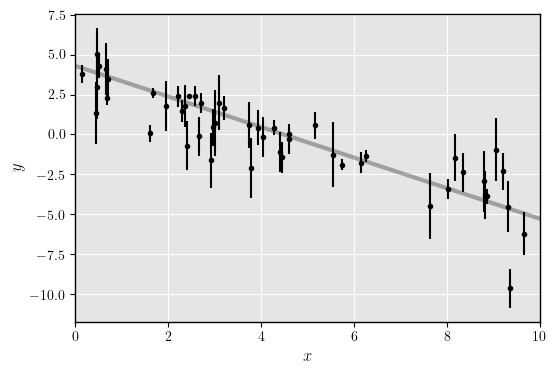

In [4]:
m_true = -0.9594
b_true = 4.294
f_true = 0.3

data = af.generate_data(50, m_true, b_true, f_true)

x = data[0]
y = data[1]
yerr = data[2]

# Plot the data
plt.figure(figsize=(6, 4))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [14]:
ndim = 3
nwalkers = 16

locs = np.array([np.arctan(m_true)-0.3, b_true-3., np.log(f_true)-3])
scales = np.array([0.6, 6., 6.])

p0 = af.generate_p0(nwalkers, locs, scales)
p0

array([[-0.62840686,  4.67653494,  1.71609124],
       [-0.47430539,  2.65281128, -1.01504552],
       [-0.49420211,  4.65569147,  1.01682194],
       [-0.51348152,  3.58543037, -0.64257803],
       [-0.94735007,  3.9078644 , -3.04580272],
       [-0.68908486,  5.40278278, -1.24176637],
       [-0.70777194,  3.99920145, -1.67820958],
       [-0.80678089,  3.78126119, -2.51893791],
       [-0.71351558,  4.12664615,  1.02691589],
       [-0.90521984,  4.46681685, -2.15541606],
       [-0.83001538,  2.09184288, -1.55646286],
       [-0.82378534,  6.39888516,  0.39712699],
       [-0.893598  ,  2.08564458,  1.11312603],
       [-1.04592559,  1.39435262, -3.53406333],
       [-0.94182794,  6.64924933, -3.961504  ],
       [-0.71247778,  4.25109632, -1.31926106]])

# Affine invariant

In [15]:
t0 = time()
chain = af.mcmc(5000, nwalkers, data, p0, locs, scales, True)
t1 = time()
print(f"Time taken: {t1-t0} s")

Acceptance rate: 0.64545
Time taken: 0.3783838748931885 s


100%|██████████| 5000/5000 [00:00<00:00, 13291.38it/s]

In [ ]:
# %%timeit -n 3 -r 5

# chain = MCMC.run_mcmc(1000, 20, parallel=True)

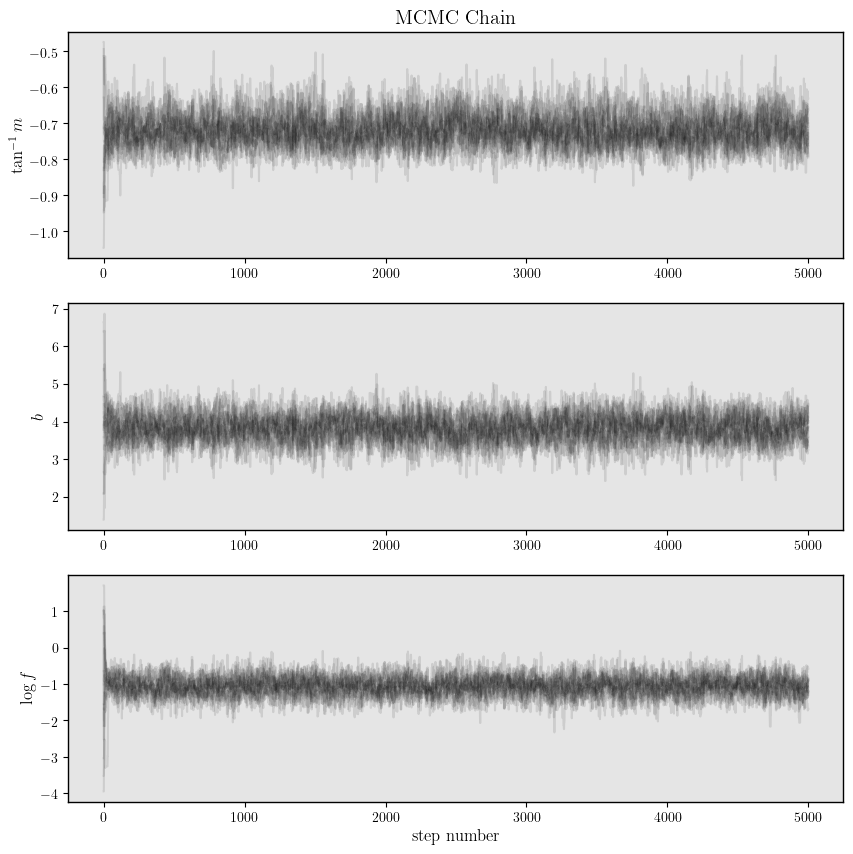

In [16]:
# plot the chain
labels = [r"$\tan^{-1} m$", r"$b$", r"$\log f$"]
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].set_title("MCMC Chain")
for i, label in enumerate(labels):
    ax[i].plot(chain[:, :, i], alpha=0.1, color="k")
    ax[i].set_ylabel(label)
    ax[i].grid(False)
ax[-1].set_xlabel("step number")
plt.show()

In [17]:
def get_chain(chain, burnin=0):
    new_chain =  chain[burnin:, :, :].copy()
    return new_chain.reshape((-1, 3))


In [18]:
burn = 100
flat = get_chain(chain, burn)
flat


array([[-0.70912223,  3.89374642, -1.6829965 ],
       [-0.76181853,  3.82800874, -0.82536117],
       [-0.70703246,  3.7284623 , -1.13200949],
       ...,
       [-0.73622689,  3.74838328, -0.9176676 ],
       [-0.73946427,  4.11816952, -1.24269012],
       [-0.70980349,  3.54641986, -0.87155352]])

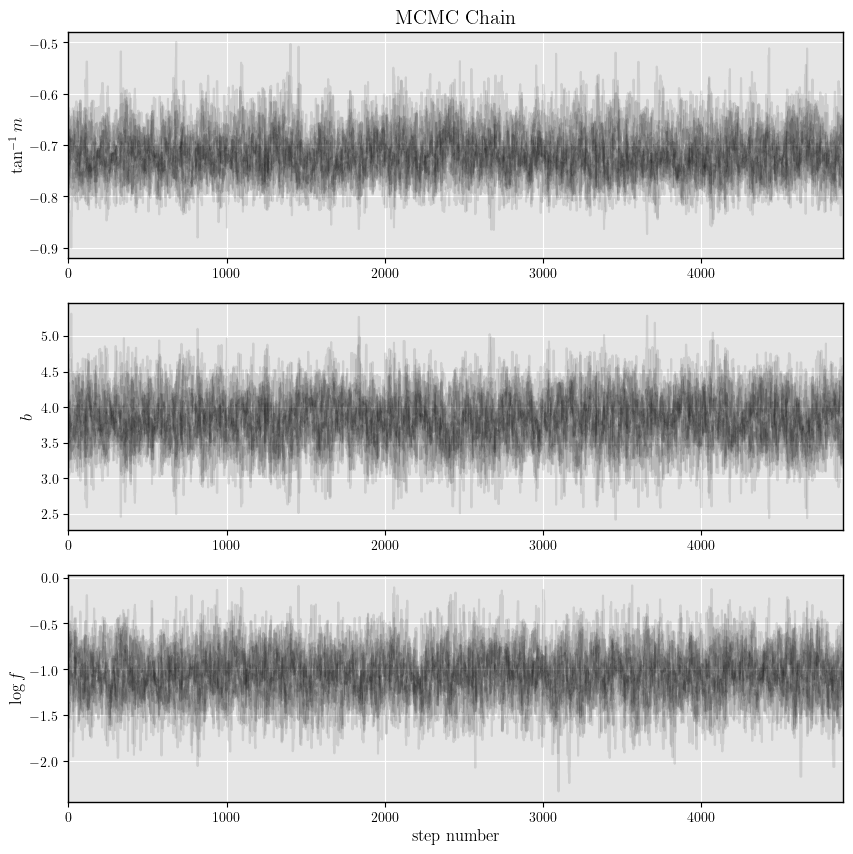

In [19]:
# plot the chain
labels = [r"$\tan^{-1} m$", r"$b$", r"$\log f$"]
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].set_title("MCMC Chain")
for i, label in enumerate(labels):
    ax[i].plot(chain[burn:, :, i], alpha=0.1, color="k")
    ax[i].set_ylabel(label)
    ax[i].set_xlim(0, 5000-burn)
ax[-1].set_xlabel("step number")
plt.show()

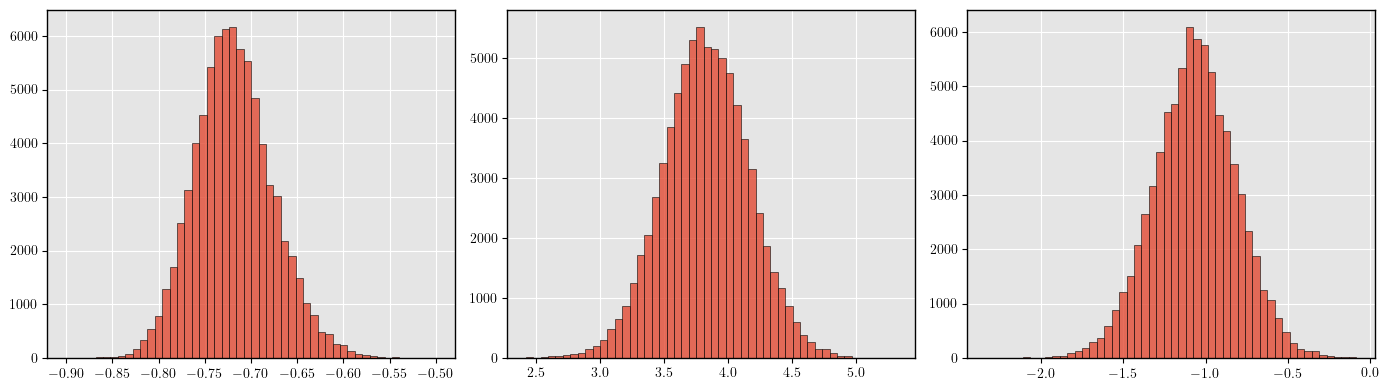

In [20]:
# plot in subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    axes[i].hist(flat[:, i], bins=50, histtype="bar", alpha=0.8, ec="k", lw=0.5)
fig.tight_layout()
plt.show()


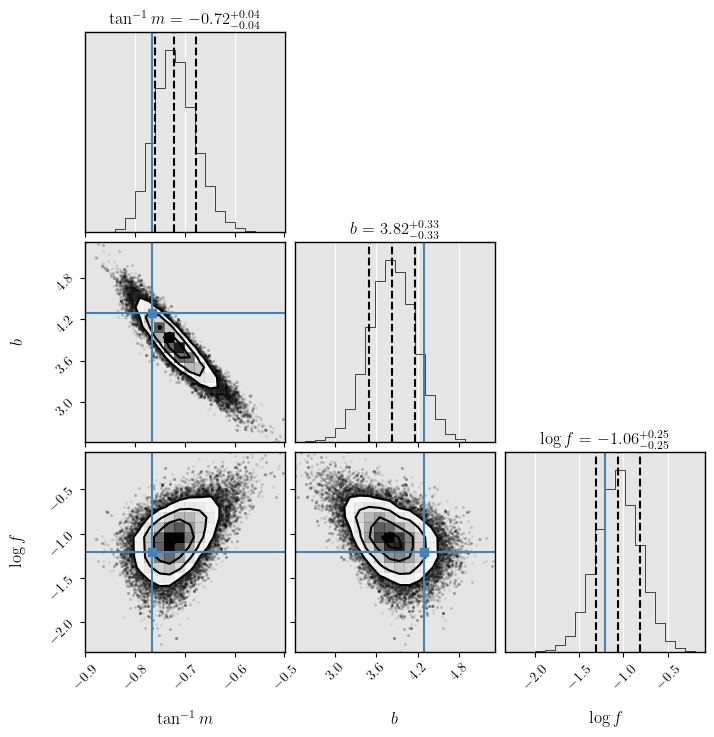

In [22]:
import corner

# plot in corner
flat = get_chain(chain, burn)

fig = corner.corner(
    flat, 
    labels=labels, 
    truths=[np.arctan(m_true), b_true, np.log(f_true)],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
plt.show()


# emcee

In [23]:
def log_likelihood(theta, x, y, yerr):
    if len(theta.shape) == 1:
        atan_m, b, log_f = theta
        y_mod = np.tan(atan_m) * x + b
        sigma2 = yerr**2 + y_mod**2 * np.exp(2 * log_f)
        return -0.5 * np.sum((y - y_mod) ** 2 / sigma2 + np.log(sigma2))
    else:
        atan_m, b, log_f = theta[:,0], theta[:,1], theta[:,2]
        N = len(atan_m)
        M = len(x)
        y_mod = np.repeat(np.tan(atan_m), M).reshape(N, M) * np.repeat(x, N).reshape(M, N).T + np.repeat(b, M).reshape(N, M)
        sigma2 = np.repeat(yerr**2, N).reshape(M, N).T + y_mod**2 * np.exp(2 * np.repeat(log_f, M).reshape(N, M))
        return -0.5 * np.sum((y - y_mod) ** 2 / sigma2 + np.log(sigma2), axis=1)

In [24]:
log_likelihood(p0, x, y, yerr), log_likelihood(p0, x, y, yerr).shape

(array([ -124.54873521,   -65.0535688 ,  -150.5096568 ,   -93.41877273,
         -388.28034046,  -123.48186606,   -40.06916293,   -93.13636148,
          -85.24266787,  -101.64081884,  -337.04847958,   -93.41693942,
         -139.02616811, -2165.71233716,  -179.19235718,   -43.01503885]),
 (16,))

In [25]:
from scipy.stats import uniform

def log_prior(theta, locs, scales):
    atan_m, b, log_f = None, None, None
    if len(theta.shape) == 1:
        atan_m, b, log_f = theta
    else:
        atan_m, b, log_f = theta[:,0], theta[:,1], theta[:,2]

    prob_m = uniform.pdf(atan_m, loc=locs[0], scale=scales[0])
    prob_b = uniform.pdf(b, loc=locs[1], scale=scales[1])
    prob_f = uniform.pdf(log_f, loc=locs[2], scale=scales[2])
    return prob_m+prob_b+prob_f 

In [26]:
log_prior(p0, locs, scales), log_prior(p0, locs, scales).shape

(array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
 (16,))

In [27]:
def log_probability(theta, x, y, yerr):
    log_prior_ = log_prior(theta, locs, scales)
    return np.select([np.isinf(log_prior_)], [-np.inf], default=log_prior_+log_likelihood(theta, x, y, yerr))
    

In [28]:
log_probability(p0, x, y, yerr), log_probability(p0, x, y, yerr).shape

(array([ -122.54873521,   -63.0535688 ,  -148.5096568 ,   -91.41877273,
         -386.28034046,  -121.48186606,   -38.06916293,   -91.13636148,
          -83.24266787,   -99.64081884,  -335.04847958,   -91.41693942,
         -137.02616811, -2163.71233716,  -177.19235718,   -41.01503885]),
 (16,))

In [30]:
from multiprocessing import Pool
import os
import emcee
os.environ["OMP_NUM_THREADS"] = "8"

In [31]:
# %%timeit

t0 = time()
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(x, y, yerr), pool=pool
    )
    sampler.run_mcmc(p0, 5000, progress=True)
t1 = time()
print(f"Time taken: {t1-t0} s")

100%|██████████| 5000/5000 [00:35<00:00, 140.47it/s]

Time taken: 35.85115623474121 s


In [32]:
flat_samples = sampler.get_chain(discard=500, flat=True)
print(flat_samples.shape)

(72000, 3)


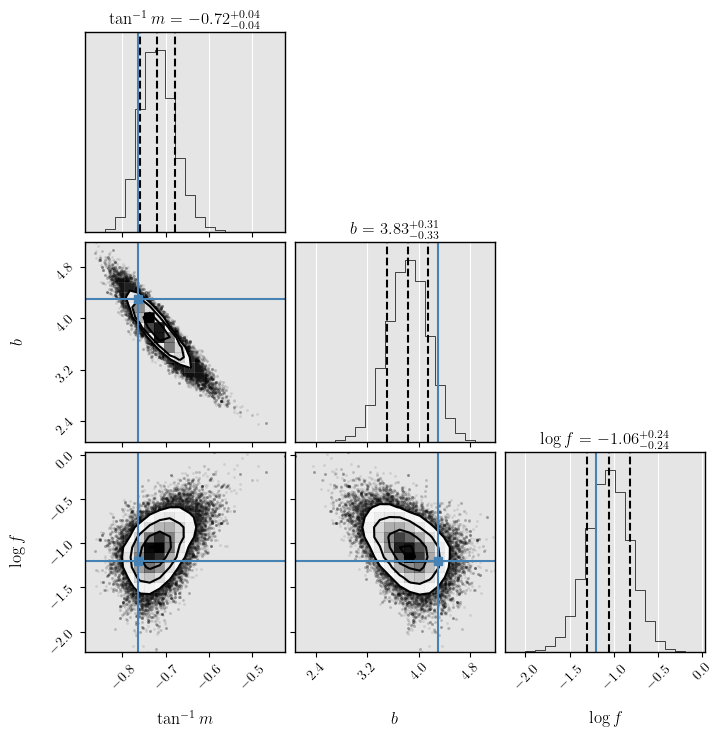

In [33]:
corner.corner(
    flat_samples, 
    labels=labels, 
    truths=[np.arctan(m_true), b_true, np.log(f_true)], 
    quantiles=[0.16, 0.5, 0.84], 
    title_kwargs={"fontsize": 12},
    show_titles=True
)
plt.show()

In [34]:
35.85115623474121/0.3783838748931885

94.74810797595802